In [1]:
import healpy as hp
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import os
import matplotlib.pyplot as plt
from healpy import read_map
tf.keras.backend.clear_session() #clear any previous models

data_directory = "/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkySimulation/data/"
os.chdir(data_directory)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1' #disable GPU
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  #suppress TF warnings
print("Current working directory:", os.getcwd())

2025-08-08 19:58:03.781153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-08 19:58:04.512373: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-08 19:58:04.592316: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/gr/lib64
2025-08-08 19:58:04.592335: I 

Current working directory: /mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkySimulation/data


In [2]:
from astropy.io import fits
def read_map(file_path):
    """
    Reads a Healpy map from a FITS file and flattens the data.
    """
    
    with fits.open(file_path) as hdul:
        hdul.info()
        if len(hdul) > 1 and hasattr(hdul[1], 'columns'):
            print(hdul[1].columns)
        return np.concatenate(hdul[1].data['T'])

Filename: ./simulated_maps/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
NSIDE: 256


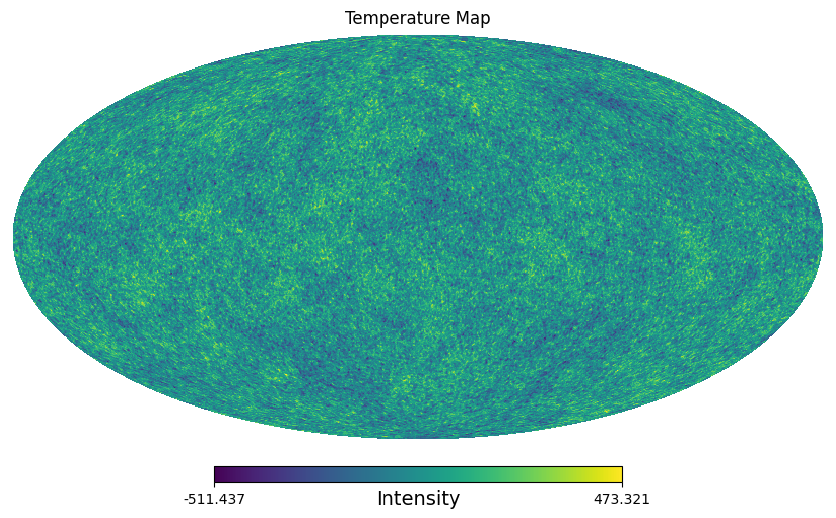

In [3]:
#Read the data
path_lcdm = "./simulated_maps/"
map_temp_data = read_map(path_lcdm + 'cmb_map_0.fits')

#Visualize the map
nside = hp.npix2nside(len(map_temp_data))
#nside = 64
print(f"NSIDE: {nside}")

#Plot
hp.mollview(map_temp_data, title="Temperature Map", unit="Intensity")
plt.show()

In [4]:
def read_all_maps(path_lcdm, path_feature, n_maps=100):
    maps = []
    labels = []
    
    #LCDM maps
    for i in range(n_maps):
        map_lcdm = read_map(f"{path_lcdm}cmb_map_{i}.fits")
        maps.append(map_lcdm)
        labels.append(0)  #lcdm
    
    #Feature maps
    for i in range(n_maps):
        map_feature = read_map(f"{path_feature}cmb_map_feature_{i}.fits")
        maps.append(map_feature)
        labels.append(1)  #feature
    
    maps = np.array(maps).astype(np.float32)[..., None]  #Add channel dimension
    labels = np.array(labels).astype(np.int32)
    #print(labels)
    return maps, labels

In [5]:
def map_to_image(hp_map, xsize=256):
    #Validate that map has correct length
    hp_map = np.asarray(hp_map, dtype=np.float64)
    try:
        nside = hp.get_nside(hp_map)
    except Exception as e:
        print("Invalid map shape:", hp_map.shape)
        raise e
    img = hp.cartview(hp_map, xsize=xsize, return_projected_map=True, title="", cbar=False)
    plt.close()
    return img

In [6]:
path_feature = "./simulated_maps/"
x_raw, y_raw = read_all_maps(path_lcdm, path_feature, n_maps=225) #0: lcdm, 1:feature

Filename: ./simulated_maps/cmb_map_0.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C   [1024D]   
ColDefs(
    name = 'T'; format = '1024D'
)
Filename: ./simulated_maps/cmb_map_3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  xtension      1 BinTableHDU     18   768R x 1C  

In [7]:
x_raw_new = np.array(x_raw).squeeze()

In [8]:
imgs = np.array([map_to_image(m) for m in x_raw_new])
if imgs.ndim == 3:
    imgs = imgs[..., np.newaxis]  #add channel dimension

In [10]:
# Compare two HEALPix maps on the sphere

# 1) Mollweide full-sky view
def compare_maps_spherical(A, B, titleA="Map A", titleB="Map B", unit="μK", 
                            lon_center=0, lat_center=0, patch_size=800, patch_reso=5):
    """
    Compare two HEALPix maps on the sphere:
    - Mollweide projection for both maps and their difference
    - Zoomed gnomonic patches
    - Angular power spectra
    """
    #common scale for fair visual comparison
    vmin = np.percentile(np.concatenate([A, B]), 0.5)
    vmax = np.percentile(np.concatenate([A, B]), 99.5)
    diff = B - A

    plt.figure(figsize=(12,4))
    hp.mollview(A, title=titleA, unit=unit, min=vmin, max=vmax, cmap="coolwarm", sub=(1,3,1))
    hp.mollview(B, title=titleB, unit=unit, min=vmin, max=vmax, cmap="coolwarm", sub=(1,3,2))
    hp.mollview(diff, title=f"{titleB} - {titleA}", unit=unit, cmap="coolwarm", sub=(1,3,3))
    plt.tight_layout()


### 2) Zoomed gnomonic patches

def compare_maps_patches(A, B, titleA="Map A", titleB="Map B", 
                      lon_center=0, lat_center=0, patch_size=800, patch_reso=5):
    """ Compare two HEALPix maps in zoomed patches:
    - Gnomonic projections for both maps and their difference
    - Angular power spectra (commented out)
    """
    #common scale for fair visual comparison
    vmin = np.percentile(np.concatenate([A, B]), 0.5)
    vmax = np.percentile(np.concatenate([A, B]), 99.5)
    diff = B - A

    plt.figure(figsize=(12,4))
    hp.gnomview(A, rot=(lon_center, lat_center), xsize=patch_size, reso=patch_reso, 
                title=f"{titleA} patch", cmap="coolwarm", min=vmin, max=vmax, sub=(1,3,1))
    hp.gnomview(B, rot=(lon_center, lat_center), xsize=patch_size, reso=patch_reso, 
                title=f"{titleB} patch", cmap="coolwarm", min=vmin, max=vmax, sub=(1,3,2))
    hp.gnomview(diff, rot=(lon_center, lat_center), xsize=patch_size, reso=patch_reso, 
                title="Difference patch", cmap="coolwarm", sub=(1,3,3))
    plt.tight_layout()


/tmp/ipykernel_2213707/1388388878.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


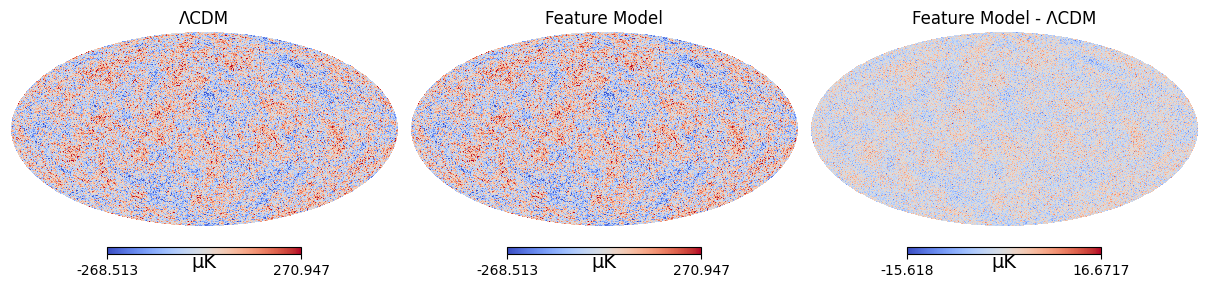

In [11]:
compare_maps_spherical(x_raw_new[0], x_raw_new[225], titleA="ΛCDM", titleB="Feature Model", lon_center=0, lat_center=0)
plt.savefig("/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkyNeuralNets/plots/comparison_maps.png", dpi=300)

/tmp/ipykernel_2213707/1388388878.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


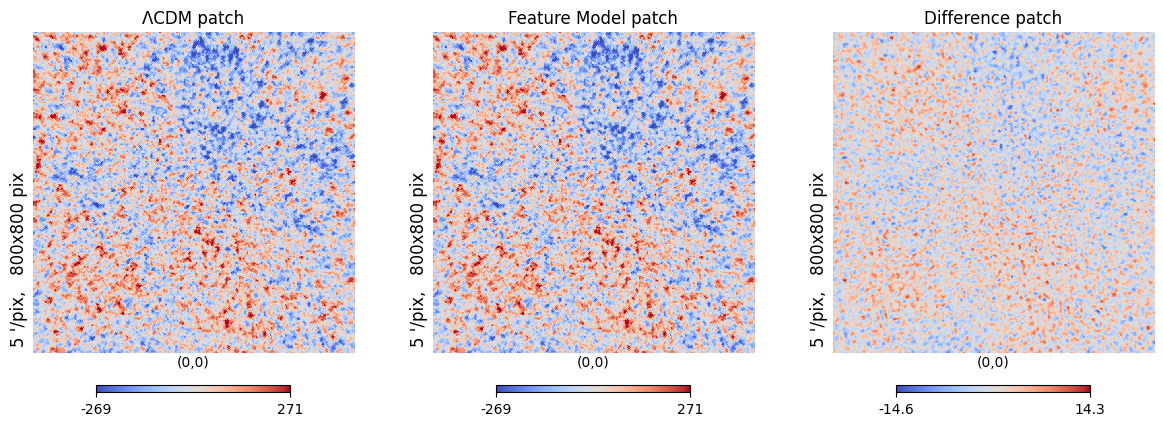

In [12]:
compare_maps_patches(x_raw_new[0], x_raw_new[225], titleA="ΛCDM", titleB="Feature Model", lon_center=0, lat_center=0)
plt.savefig("/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkyNeuralNets/plots/comparison_patches.png", dpi=300)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs, y_raw, test_size=0.2, random_state=15)
X_test, X_val, y_test, y_val = train_test_split(imgs, y_raw, test_size=0.2, random_state=15)

In [14]:
def z_score_norm(X_train, X_test, X_val):

    """Compute μ,σ on TRAIN ONLY; apply to all splits. Returns scaled arrays + (μ,σ)."""
    mu  = X_train.mean(dtype=np.float64)
    std = X_train.std(dtype=np.float64)
    # avoid divide-by-zero
    std = std if std > 0 else 1.0

    def _scale(Z): return ((Z - mu) / std).astype(np.float32)
    return _scale(X_train), _scale(X_test),  _scale(X_val), (float(mu), float(std))

In [15]:
X_train, X_test, X_val, (mu, std) = z_score_norm(X_train, X_test, X_val)

In [16]:
#======== Define Model ========
model = models.Sequential([
    layers.Input(shape=imgs.shape[1:]),        

    layers.Conv2D(32, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), padding="same", use_bias=False),
    layers.BatchNormalization(), layers.ReLU(),

    layers.GlobalAveragePooling2D(),             
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu",
                 kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid"),
])

2025-08-08 20:12:35.476462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /mnt/netapp1/Optcesga_FT2_RHEL7/2020/gentoo/22072020/usr/gr/lib64
2025-08-08 20:12:35.476677: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-08-08 20:12:35.476695: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login210-19): /proc/driver/nvidia/version does not exist
2025-08-08 20:12:35.477795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)
model.summary(110)

Model: "sequential"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 conv2d (Conv2D)                                 (None, 128, 256, 32)                        288              
                                                                                                              
 batch_normalization (BatchNormalization)        (None, 128, 256, 32)                        128              
                                                                                                              
 re_lu (ReLU)                                    (None, 128, 256, 32)                        0                
                                                                                                              
 max_pooling2d (MaxPooling2D)                    (None, 64, 128, 32)                        

In [18]:
cb = [
  tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=150, mode="max", restore_best_weights=True),
  tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", factor=0.5, patience=4, mode="max", min_lr=1e-6)
]

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), callbacks=cb)

Epoch 1/500
12/12 [==============================] - 10s 746ms/step - loss: 0.7135 - accuracy: 0.4833 - auc: 0.5121 - val_loss: 0.6970 - val_accuracy: 0.5444 - val_auc: 0.5612 - lr: 1.0000e-04
Epoch 2/500
12/12 [==============================] - 7s 584ms/step - loss: 0.7164 - accuracy: 0.5083 - auc: 0.5166 - val_loss: 0.6961 - val_accuracy: 0.5444 - val_auc: 0.6384 - lr: 1.0000e-04
Epoch 3/500
12/12 [==============================] - 7s 555ms/step - loss: 0.6875 - accuracy: 0.5917 - auc: 0.6086 - val_loss: 0.6938 - val_accuracy: 0.5444 - val_auc: 0.6234 - lr: 1.0000e-04
Epoch 4/500
12/12 [==============================] - 7s 546ms/step - loss: 0.6755 - accuracy: 0.5972 - auc: 0.6335 - val_loss: 0.7158 - val_accuracy: 0.4556 - val_auc: 0.6379 - lr: 1.0000e-04
Epoch 5/500
12/12 [==============================] - 6s 509ms/step - loss: 0.6648 - accuracy: 0.6111 - auc: 0.6506 - val_loss: 0.7726 - val_accuracy: 0.4556 - val_auc: 0.6533 - lr: 1.0000e-04
Epoch 6/500
12/12 [====================

In [19]:
test_loss, test_acc, test_auc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

12/12 [==============================] - 2s 155ms/step - loss: 1.1487 - accuracy: 0.5111 - auc: 0.9988
Test accuracy: 0.5111


Text(0, 0.5, 'Accuracy')

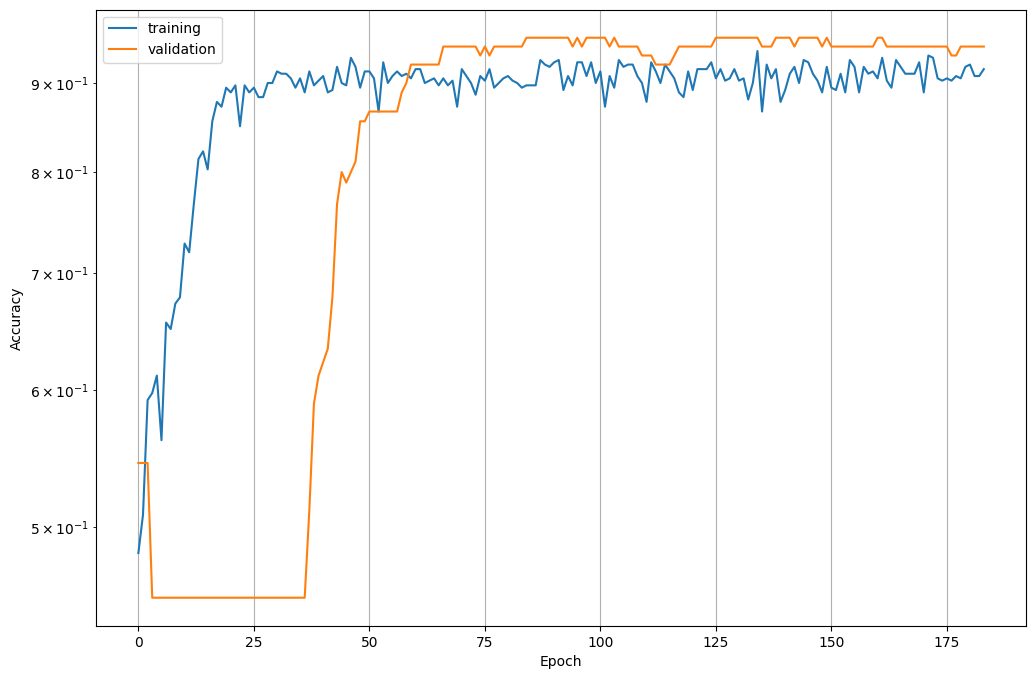

In [20]:
plt.figure(figsize=(12,8))
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

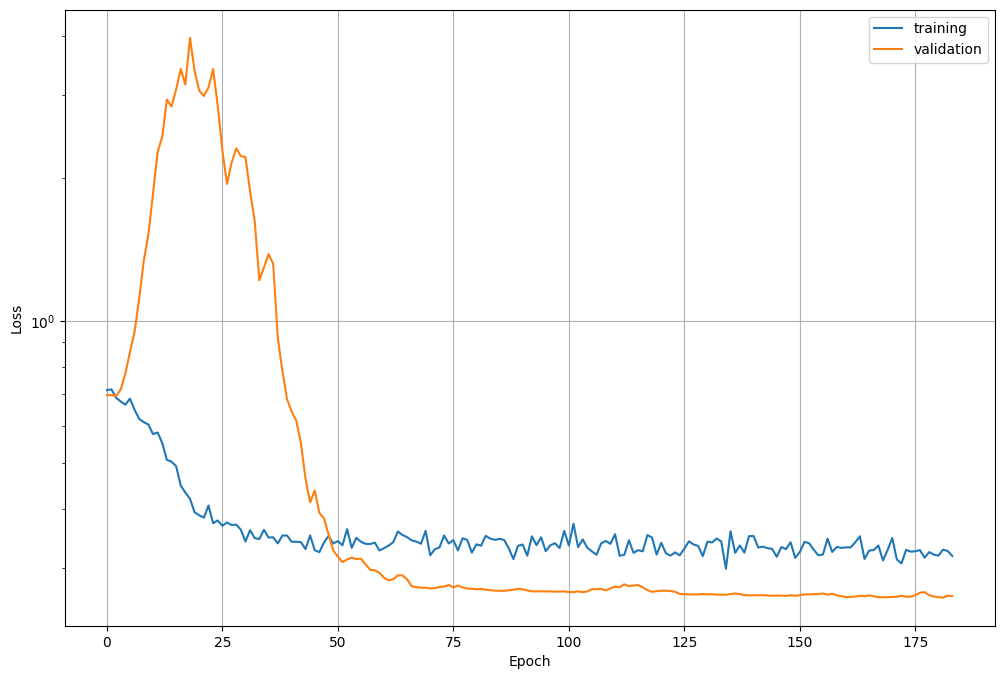

In [21]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [22]:
#sanity check
print(np.mean(X_train), np.std(X_train))   #mean~0, st.dev~1
print(np.mean(X_test),  np.std(X_test))    #should be close to train

-2.7939678e-10 0.9999999
-2.7939678e-10 0.9999999


In [24]:
# Get model probabilities
probs = model.predict(X_test, batch_size=64).ravel()

6/6 [==============================] - 2s 281ms/step


In [25]:
#Check the class balance, do we have a 50/50 split?
print("class balance test:", (y_test==1).mean())

class balance test: 0.4888888888888889


In [26]:
#Let's check the ranges of probabilities, why is the CNN classfiying everything as LCDM?
print("min/max/mean probs:", probs.min(), probs.max(), probs.mean())

min/max/mean probs: 0.023230594 0.3883231 0.07519614


In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

#Find optimal threshold from ROC
fpr, tpr, thr = roc_curve(y_test, probs)
t_opt = thr[np.argmax(tpr - fpr)]
print("AUC:", auc(fpr, tpr), "t*:", t_opt)

#Apply the new threshold to get predictions, Youden's index https://en.wikipedia.org/wiki/Youden%27s_J_statistic
pred = (probs >= t_opt).astype(int)

#Accuracy
acc = accuracy_score(y_test, pred)
print("Accuracy:", acc)

#Confusion matrix
cm = confusion_matrix(y_test, pred, labels=[0, 1])
print("Confusion matrix:\n", cm)


AUC: 0.9996603260869564 t*: 0.032936398
Accuracy: 0.9972222222222222
Confusion matrix:
 [[184   0]
 [  1 175]]


In [29]:
#-----------------------------------------------------------------------------------------------------------
#Performance: correct & incorrect  predictions
#-----------------------------------------------------------------------------------------------------------
#True positive: LCDM=0, Feature=1
true_LCDM = []
true_MoG = []
false_LCDM = []
false_MoG = []

for pred, true in zip(pred, y_test):
    if pred==0 and true==0:
        true_LCDM.append(1)
    if pred==1 and true==1:
        true_MoG.append(1)
    if pred==0 and true==1:
        false_LCDM.append(1)
    if pred==1 and true==0:
        false_MoG.append(1)
lenghts=[len(true_LCDM),len(true_MoG),len(false_LCDM),len(false_MoG)]

print('     ','LCDM','FT')
print('True ',len(true_LCDM)/sum(lenghts),len(true_MoG)/sum(lenghts))
print('False',len(false_LCDM)/sum(lenghts),len(false_MoG)/sum(lenghts))
print('--------------')
print("Correct prediction: ",(len(true_LCDM)+len(true_MoG))/sum(lenghts))
print("Wrong prediction  : ",(len(false_LCDM)+len(false_MoG))/sum(lenghts))

      LCDM FT
True  0.5111111111111111 0.4861111111111111
False 0.002777777777777778 0.0
--------------
Correct prediction:  0.9972222222222222
Wrong prediction  :  0.002777777777777778


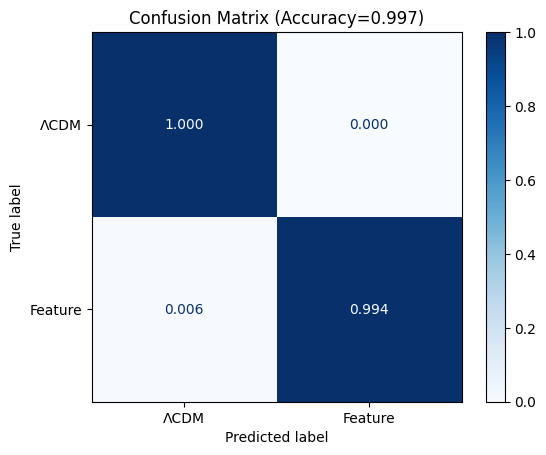

In [45]:
#Plot confusion matrix
cm_prob = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_prob, display_labels=["ΛCDM", "Feature"])
disp.plot(cmap="Blues", values_format='.3f')
plt.title(f"Confusion Matrix (Accuracy={acc:.3f})")
plt.savefig("/mnt/lustre/scratch/nlsas/home/csic/eoy/ioj/SkyNeuralNets/plots/confusion_matrix.png", dpi=300)
plt.show()

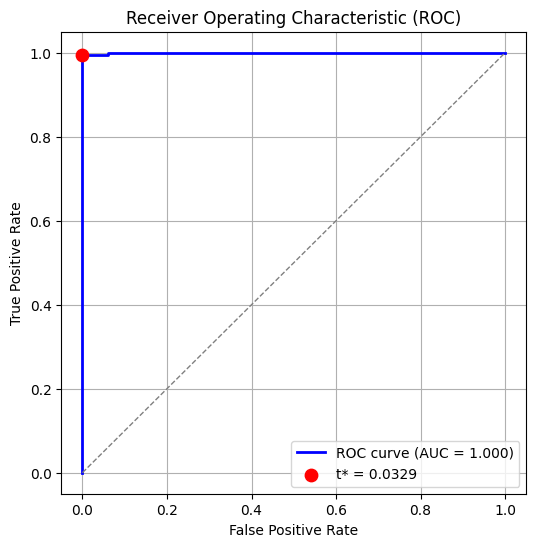

In [30]:
#Plot the ROC curve with Youden index (https://en.wikipedia.org/wiki/Youden%27s_J_statistic#/media/File:ROC_Curve_T1D_Validation,_top5_r2filtered.svg)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")

t_star_idx = np.argmax(tpr - fpr)
t_star = thr[t_star_idx]

#Mark t* point
plt.scatter(fpr[t_star_idx], tpr[t_star_idx], color="red", s=80, zorder=5,
            label=f"t* = {t_star:.4f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()